In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import shutil

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.models as models

from utils.datasets import ImageFolderWithPath
def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
# モデル設定
arch = "resnet18"
num_classes = 37
data_dir = "./data"
batch_size = 256
workers = 4

## 評価用データに対して予測

In [3]:
#model 読み込み
model = models.__dict__[arch](num_classes = num_classes).cuda()
model = torch.nn.DataParallel(model).cuda()
checkpoint = torch.load("./model_best.pth.tar")
model.load_state_dict(checkpoint['state_dict'])
model.eval()

# データセット
testdir = os.path.join(data_dir, 'val')
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
test_dataset = ImageFolderWithPath(
    testdir,
    transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ]))
test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size, shuffle=False,
        num_workers=workers, pin_memory=True)

# 予測
hold_num = len(test_dataset)
test_pred = torch.zeros(hold_num, num_classes)
test_ans = torch.zeros(hold_num).long()
test_path = []
start_idx = 0
for i, ((input, target), path) in enumerate(test_loader):
    target = target.cuda(async=True)
    input_var = torch.autograd.Variable(input, volatile=True)
    target_var = torch.autograd.Variable(target, volatile=True)
    
    # compute output
    output = model(input_var).data.cpu()
    b_size = output.size(0)
    test_pred[start_idx:(start_idx + b_size),:] = output
    test_ans[start_idx:(start_idx + b_size)] = target
    start_idx += b_size
    test_path.extend(path)

In [4]:
#ans_path = pd.DataFrame({"ans":test_ans.numpy(), "path":test_path})
#data = pd.concat((test_pred, ans_path), axis=1) 

## 予測値および正解データ

In [5]:
#data = pd.read_csv("latest_res.csv")
test_pred = pd.DataFrame(test_pred.numpy())
ans_path = pd.DataFrame({"ans":test_ans.numpy(), "path":test_path})
data = pd.concat((test_pred, ans_path), axis=1)  

In [6]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,ans,path
0,10.521819,8.225688,-4.679379,-1.688009,5.077665,5.338161,5.018577,2.297347,-0.666444,0.059624,...,-1.523196,-1.723941,-3.120933,-2.294384,0.335584,-3.139529,-0.406684,-0.338420,0,./data/val/Abyssinian/Abyssinian_103.jpg
1,18.320724,7.108580,-4.133904,-2.512592,9.844354,5.528077,6.329695,-1.099433,1.311278,7.464172,...,-5.111319,-2.135528,-3.565389,-4.903440,6.168525,-3.213504,-2.451611,-4.903779,0,./data/val/Abyssinian/Abyssinian_122.jpg
2,8.607668,3.278526,-1.098889,-2.040444,2.264313,3.349949,3.384401,-1.312589,2.029163,2.623142,...,-1.028348,-2.280293,-0.996928,-2.151406,3.174000,-4.126347,-0.110736,0.335808,0,./data/val/Abyssinian/Abyssinian_133.jpg
3,6.074600,3.653526,-1.936424,-0.004229,2.715490,2.421818,1.640337,-0.997488,1.107398,4.313754,...,-1.200994,-1.196173,-0.961108,1.144778,-0.418347,-2.215107,0.869889,-0.973664,0,./data/val/Abyssinian/Abyssinian_158.jpg
4,12.391636,7.720150,-2.521337,-2.763374,-0.029750,1.543300,1.228433,-7.260141,-0.209846,1.964450,...,-3.787139,0.088775,-4.816115,-3.151484,6.231383,-1.864267,-1.797342,0.226769,0,./data/val/Abyssinian/Abyssinian_159.jpg


## 精度

In [7]:
data["pred_lab"] = data.iloc[:,:-2].values.argmax(axis=1)
(data.pred_lab == data.ans).mean()

0.8075880758807588

## 予測ラベルとクラス名対応表

In [8]:
lab_ref = pd.read_csv("lab_ref.csv")
lab_ref_dict = {}
for i in range(lab_ref.shape[0]):
    lab_ref_dict[i] = lab_ref.name[i]

In [9]:
lab_ref

,id,name
0,0,Abyssinian
1,1,Bengal
2,2,Birman
3,3,Bombay
4,4,British_Shorthair
5,5,Egyptian_Mau
6,6,Maine_Coon
7,7,Persian
8,8,Ragdoll
9,9,Russian_Blue


In [10]:
l = lab_ref.shape[0]

In [11]:
ans_cat = pd.Categorical(data.ans.values, categories=np.arange(l).astype(int))
pred_cat = pd.Categorical(data.iloc[:,:l].values.argmax(axis=1), categories=np.arange(l).astype(int))
conf_mat = pd.crosstab(ans_cat, pred_cat) # ans * pred

In [12]:
conf_mat

col_0,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
row_0,,,,,,,,,,,,,,,,,,,,,
0,15,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,17,0,0,0,0,2,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,17,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,17,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,13,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0
5,1,1,0,1,0,15,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,3,0,0,0,0,16,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,1,0,0,1,18,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,18,0,...,0,0,0,0,0,0,0,0,0,0


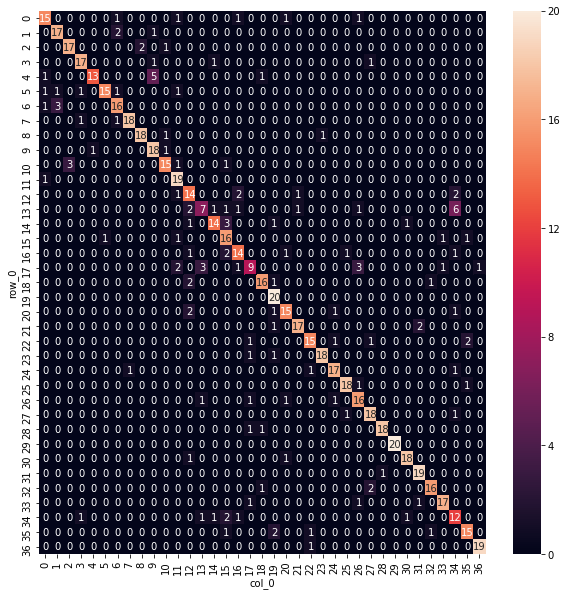

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt="d",ax=ax)

# レポート用結果保存

In [14]:
mkdir("./result")
lab_ref.sort_values("id", inplace=True)
# 予測値、結果データ
scores = data.iloc[:,:lab_ref.shape[0]].values
ex_scores = np.exp(scores)
probs = ex_scores / ex_scores.sum(axis=1, keepdims=True)
probs = pd.DataFrame(probs)
probs.columns = lab_ref.name.values
pred_results = pd.concat([probs, data[["ans", "path","pred_lab"]]], axis=1)
pred_results.head()
pred_results.to_csv("./result/prediction.csv", index=False)

In [15]:
# 誤判別画像フォルダ
mkdir("./result/fail_imgs")
data["correct"] = data.ans == data.pred_lab
fail_data = data.iloc[~data.correct.values,:]
fail_data.reset_index(inplace=True)
fail_data.head()
for i in range(fail_data.shape[0]):
    ans_lab = lab_ref_dict[fail_data.ans[i]]
    output_dir = os.path.join("./result/fail_imgs", ans_lab)
    mkdir(output_dir)
    pred_lab = lab_ref_dict[fail_data.pred_lab[i]]
    from_path = fail_data.path[i]
    to_name = str(pred_lab) + "_" + os.path.basename(from_path)
    to_path = os.path.join(output_dir, to_name)
    shutil.copy(from_path, to_path)

In [16]:
# confusion matrix (ans * pred)
l = lab_ref.shape[0]

nums = conf_mat.values.astype(float)
prec = np.diag(nums)/nums.sum(axis=0)
recall = np.diag(nums)/nums.sum(axis=1)

conf_result = np.zeros((l+1, l+1))
conf_result[:l, :l] = conf_mat.values
conf_result[l,:l] = prec
conf_result[:l,l] = recall
conf_result = pd.DataFrame(conf_result)
conf_result.columns =  list(lab_ref.name.values) + ["recall"]
conf_result.index = list(lab_ref.name.values) + ["precision"]
conf_result.to_csv("result/conf_mat.csv")
